In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
from utils_data import get_numbered_binary_tags, get_datasets, get_layers

In [2]:
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 6,          # Title size for axes
    'axes.labelsize': 6,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 6,        # Overall figure title size
})
model_name = 'llama-3.1-8b'

In [3]:
METHODS = ['logreg', 'pca', 'knn', 'xgboost', 'mlp']
METHOD_MAP = {'logreg': 'Logistic Reg.', 'pca': 'PCA', 'knn': 'KNN', 'xgboost': 'XGBoost', 'mlp': 'MLP'}
LAYERS = get_layers(model_name)
def read_layer_normal(layer = 8):
    assert layer in LAYERS
    return pd.read_csv(f'results/baseline_probes_{model_name}/normal_settings/layer{layer}_results.csv')

def read_layer_method_normal(layer, method):
    assert method in METHODS
    df = read_layer_normal(layer)
    return df[df['method'] == method]

len(read_layer_method_normal(8, 'pca'))

113

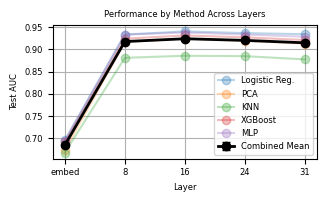

In [7]:
def plot_normal_avg_layer():
    x_coords = np.arange(len(LAYERS))
    
    plt.figure(figsize = (3.25,2))
    
    # Store means for combined line
    all_means = []
    
    # Plot individual method lines with opacity
    for method in METHODS:
        layer_means = []
        
        for i, layer in enumerate(LAYERS):
            df = read_layer_method_normal(layer, method)
            aucs = df['test_auc'].values
            num = len(aucs)
            mean_auc = np.mean(aucs)
            layer_means.append(mean_auc)
            
        plt.plot(x_coords, layer_means, '-o', alpha=0.3, label=METHOD_MAP[method])
        all_means.append(layer_means)
    
    # Plot combined mean line with standard error
    combined_means = np.mean(all_means, axis=0)
    combined_std = np.std(all_means, axis=0)
    combined_se = 1.96 * combined_std / np.sqrt(len(METHODS) * num)
    
    plt.errorbar(x_coords, combined_means, yerr=combined_se, fmt='-o', color='black', 
                label='Combined Mean', linewidth=2, capsize=3)
    plt.xticks(x_coords, LAYERS)
    plt.xlabel('Layer')
    plt.ylabel('Test AUC')
    plt.title('Performance by Method Across Layers')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    os.makedirs(f'figures/{model_name}/', exist_ok = True)
    plt.savefig(f'figures/{model_name}/full_baselines_by_layer_normal_{model_name}.pdf', dpi = 300)
    plt.savefig(f'figures/{model_name}/full_baselines_by_layer_normal_{model_name}.png', dpi = 300)

plot_normal_avg_layer()

# Normal

In [19]:
def read_useful_sae():
    df = pd.read_csv(f'results/sae_probes_{model_name}/normal_setting/all_metrics.csv')
    # Get the maximum k value for each width
    
    # Filter to only keep rows where k is 32 or 128
    df = df[df['k'].isin([16, 128])]
    df['method'] = 'sae_' + df['sae_id'] + '_k' + df['k'].astype(str)
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc', 'dataset', 'method']]
    return df

def arrow_quiver(sae = False):
    df = read_layer_normal()
    if sae:
        saedf = read_useful_sae()
        # Combine baseline and SAE dataframes if SAE data provided
        df = pd.concat([df, saedf], ignore_index=True)
    best_methods = df.loc[df.groupby('dataset')['val_auc'].idxmax()]
    # Calculate percentage of methods containing 'sae'
    sae_methods = best_methods['method'].str.contains('sae')
    sae_percentage = (sae_methods.sum() / len(best_methods)) * 100
    # print(f"Percentage of best methods that are SAE: {sae_percentage:.1f}%")
    # print(f'Num SAE: {sae_methods.sum()}')
    return best_methods.reset_index(drop=True)


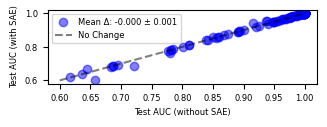

In [20]:
def plot_improvement_normal():
    nosae = arrow_quiver(sae = False)
    sae = arrow_quiver(sae = True)
    
    # Calculate mean and standard error of difference
    diff = sae['test_auc'] - nosae['test_auc']
    mean_diff = np.mean(diff)
    se_diff = np.std(diff) / np.sqrt(len(diff))
    
    plt.figure(figsize=(3.25,1.25))
    plt.scatter(nosae['test_auc'], sae['test_auc'], alpha=0.5, color = 'b',
               label=f'Mean Δ: {mean_diff:.3f} ± {se_diff:.3f}')
    
    # Add diagonal line only spanning the data range
    min_val = min(nosae['test_auc'].min(), sae['test_auc'].min())
    max_val = max(nosae['test_auc'].max(), sae['test_auc'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label = 'No Change')
    
    # Annotate points with largest absolute differences
    plt.xlabel('Test AUC (without SAE)')
    plt.ylabel('Test AUC (with SAE)')
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/{model_name}/sae_vs_nosae_normal_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/{model_name}/sae_vs_nosae_normal_comparison.png', dpi=300, bbox_inches='tight')

plot_improvement_normal()

# Scarcity

In [23]:
def read_results_scarcity(regime = 'scarcity', method = None):
    df = pd.read_csv(f'results/baseline_probes_{model_name}/{regime}/summary/all_results.csv')
    if method is not None:
        return df[df['method'] == method]
    return df

def read_saes_scarcity(setting = 'scarcity', saeid = None):
    df = pd.read_csv(f'results/sae_probes_{model_name}/{setting}_setting/all_metrics.csv')
    #df = df[df['k'] == 128]
    df['method'] = 'sae_' + df['sae_id'] + '_k' + df['k'].astype(str)
    if saeid is not None:
        df = df[df['sae_id'].str.contains(saeid)]
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc', 'dataset', 'method', 'num_train']]
    #df = df[df['method'].str.contains('1m')]
    return df

def quiver_arrows_scarcity(sae = False):
    df = read_results_scarcity()
    if sae:
        sae = read_saes_scarcity()
        df = pd.concat([df, sae], ignore_index=True)
    
    # Group by dataset and num_train, keep only row with highest val_auc
    # For ties, prefer rows with 'sae' in method name
    df['has_sae'] = df['method'].str.contains('sae')
    df['width_rank'] = df['method'].apply(lambda x: 
        1 if 'width_16k' in str(x) else
        2 if 'width_131k' in str(x) else 
        3 if 'width_1m' in str(x) else 4)
    df['k_rank'] = df['method'].apply(lambda x:
        1 if 'k128' in str(x) else
        2 if 'k16' in str(x) else 3)
    df = df.sort_values('has_sae', ascending=False)
    df = df.loc[df.groupby(['dataset', 'num_train'])['val_auc'].idxmax()]
    return df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'num_train', 'dataset']]

# Imbalance

In [25]:
def read_results_imbalance(method = None):
    df = pd.read_csv(f'results/baseline_probes_{model_name}/imbalance/all_results.csv')
    df['ratio'] = df['ratio'].round(2) # Round to 2 decimal places first 
    df['ratio'] = (df['ratio'] * 20).round() / 20 # Round to nearest 0.05
    if method is not None:
        return df[df['method'] == method]#[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio']]
    return df

def read_sae_imbalance(saeid = None):
    df = pd.read_csv(f'results/sae_probes_{model_name}/class_imbalance_setting/all_metrics.csv')
    df = df.rename(columns={'frac': 'ratio'})
    df['ratio'] = df['ratio'].round(2) # Round to 2 decimal places first 
    df['ratio'] = (df['ratio'] * 20).round() / 20 # Round to nearest 0.05
    df['method'] = 'sae_' + df['sae_id'] + '_k' + df['k'].astype(str)
    if saeid is not None:
        df = df[df['sae_id'].str.contains(saeid)]
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio', 'dataset']]
    return df.reset_index(drop = True)

def quiver_arrows_imbalance(sae = False):
    df = read_results_imbalance()
    if sae:
        sae = read_sae_imbalance()
        df = pd.concat([df, sae], ignore_index=True)
    
    # Group by dataset and num_train, keep only row with highest val_auc
    # For ties, prefer rows with 'sae' in method name
    df['has_sae'] = df['method'].str.contains('sae')
    df['width_rank'] = df['method'].apply(lambda x: 
        1 if 'width_16k' in str(x) else
        2 if 'width_131k' in str(x) else 
        3 if 'width_1m' in str(x) else 4)
    df['k_rank'] = df['method'].apply(lambda x:
        1 if 'k128' in str(x) else
        2 if 'k16' in str(x) else 3)
    df = df.sort_values('has_sae', ascending=False)
    df = df.loc[df.groupby(['dataset', 'ratio'])['val_auc'].idxmax()]
    return df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio', 'dataset']]

# Corrupt

In [27]:
def read_results_corrupt(method = None):
    df = pd.read_csv(f'results/baseline_probes_{model_name}/corrupt/all_results.csv')
    df['ratio'] = df['ratio'].round(2) # Round to 2 decimal places first 
    df['ratio'] = (df['ratio'] * 20).round() / 20 # Round to nearest 0.05
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio', 'dataset']]
    if method is not None:
        return df[df['method'] == method]
    return df

def read_sae_corrupt():
    df = pd.read_csv(f'results/sae_probes_{model_name}/label_noise_setting/all_metrics.csv')
    df = df.rename(columns={'corrupt_frac': 'ratio'})
    df['ratio'] = df['ratio'].round(2) # Round to 2 decimal places first 
    df['ratio'] = (df['ratio'] * 20).round() / 20 # Round to nearest 0.05
    df['method'] = 'sae_' + df['sae_id'] + '_k' + df['k'].astype(str)
    #print(df['method'].unique())
    df = df[df['method'] == 'sae_l16r_32x_k128'] #'sae_layer_20/width_1m/average_l0_193_k128']
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio', 'dataset']]
    return df.reset_index(drop = True)

def quiver_arrows_corrupt(sae = False):
    if sae:
        return read_sae_corrupt()
    else:
        return read_results_corrupt()


# Avg in Conditions
Fig. 19

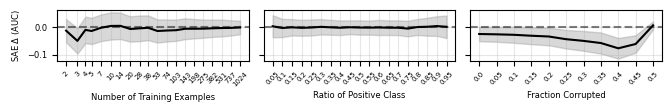

In [30]:
def plot_regime_improvements():
    fig, axs = plt.subplots(1, 3, figsize=(6.75, 1.1), sharey=True)
    
    # Define settings for each regime
    regimes = [
        ('num_train', quiver_arrows_scarcity, 'Number of Training Examples', True),
        ('ratio', quiver_arrows_imbalance, 'Ratio of Positive Class', False),
        ('ratio', quiver_arrows_corrupt, 'Fraction Corrupted', False)
    ]
    
    for i, (x_var, quiver_func, xlabel, use_log) in enumerate(regimes):
        # Get data for both SAE and non-SAE
        df_sae = quiver_func(sae=True)
        df_no_sae = quiver_func(sae=False)
        
        # Calculate statistics
        sae_stats = df_sae.groupby(x_var).agg(
            mean=('test_auc', 'mean'),
            se=('test_auc', lambda x: x.std() / np.sqrt(len(x)))
        ).reset_index()
        
        no_sae_stats = df_no_sae.groupby(x_var).agg(
            mean=('test_auc', 'mean'),
            se=('test_auc', lambda x: x.std() / np.sqrt(len(x)))
        ).reset_index()
        
        # Calculate delta and error
        delta = sae_stats['mean'] - no_sae_stats['mean']
        error = np.sqrt(sae_stats['se']**2 + no_sae_stats['se']**2)
        
        # Plot
        axs[i].plot(sae_stats[x_var], delta, 'k-')
        axs[i].fill_between(sae_stats[x_var],
                         delta - 1.96*error,
                         delta + 1.96*error,
                         color='gray', alpha=0.3)
        
        # Set scales and ticks
        if use_log:
            axs[i].set_xscale('log', base=2)
        axs[i].set_xticks(sae_stats[x_var])
        axs[i].set_xticklabels([str(x) for x in sae_stats[x_var]], rotation=45, fontsize=5)
        
        # Labels and styling
        axs[i].set_xlabel(xlabel)
        if i == 0:
            axs[i].set_ylabel(r'SAE $\Delta$ (AUC)')
        axs[i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axs[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    savename = f'figures/{model_name}/quiver_improve_regimes'
    plt.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{savename}.png', dpi=300, bbox_inches='tight')

plot_regime_improvements()